In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

from jax import config
config.update("jax_enable_x64", True)

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x = np.load('../navier_stokes_data/NavierStokes_inputs.npy').transpose((2,1,0)).reshape(40000, 64*64)
y = np.load('../navier_stokes_data/NavierStokes_outputs.npy').transpose((2,1,0)).reshape(40000, 64*64)

x_train = x[int(len(x)/5):, :]
y_train = y[int(len(y)/5):, :]

x_test = x[:int(len(x)/5), :]
y_test = y[:int(len(y)/5), :]

print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train = x_train[:1000, :]
y_train = y_train[:1000, :]

x_test = x_test[:1000, :]
y_test = y_test[:1000, :]

(40000, 4096) (40000, 4096)
(32000, 4096) (32000, 4096)
(8000, 4096) (8000, 4096)


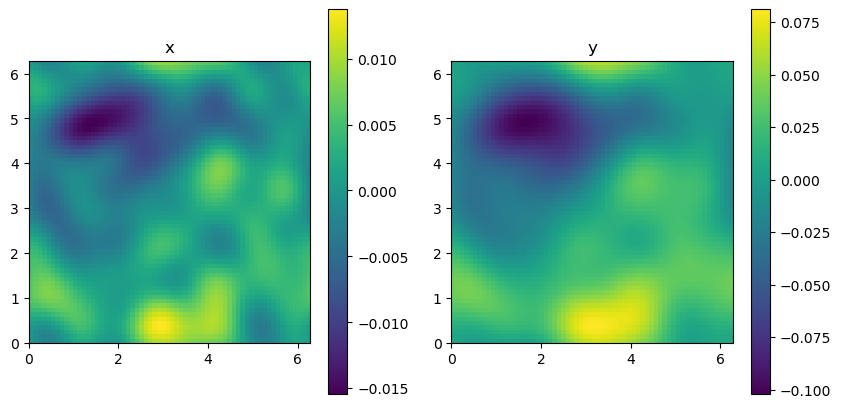

In [3]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

In [4]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

class full_model():
    def __init__(self, n, m, ARD, multiinput, standardise):
        self.n = n
        self.m = m
        self.ARD = ARD
        self.multiinput = multiinput
        self.standardise = standardise

    def fit(self, x_train, y_train, n_samples = None):

        if self.ARD:
            ls = jnp.full(self.n, 1, dtype=jnp.float64)
        else:
            ls = jnp.full((1), 1, dtype=jnp.float64)

        GP_params = {"kernel": gpx.kernels.RBF(lengthscale = ls, variance = jnp.full((1), 1, dtype=jnp.float64)), 'mean_function': gpx.mean_functions.Zero(), 'multiinput': self.multiinput}

        self.x_train = x_train
        self.y_train = y_train

        if self.m is None:
            self.m = self.y_train.shape[-1]

        self.x_pca = PCA(n_components = self.n)
        self.y_pca = PCA(n_components = self.m)
        self.x_train_pca = self.x_pca.fit_transform(self.x_train)
        print('does x pca')
        self.y_train_pca = self.y_pca.fit_transform(self.y_train)
        print('does y pca')

        self.model_list = []

        if n_samples is not None:
            train_samples_pca = np.zeros((x_train.shape[0], self.m, n_samples))
            train_samples = np.zeros((self.y_train.shape[0], self.y_train.shape[1], n_samples))

        if self.standardise:
            self.x_train_pca_stand = (self.x_train_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            self.y_train_pca_stand = (self.y_train_pca - self.y_train_pca.mean(axis = 0))/self.y_train_pca.std(axis = 0)

            if self.multiinput:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand, self.y_train_pca_stand[:, i])
                    print(local_gp.kernel.lengthscale)
                    print(local_gp.kernel.variance)
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand[:, i].reshape(-1, 1), self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)

        else:
            if self.multiinput:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca, self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca[:, i].reshape(-1, 1), self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca[:, i].reshape(-1, 1), n_samples = n_samples)

        if n_samples is not None:
            for i in range(n_samples):
                train_samples_pca_i = train_samples_pca[:, :, i]
                train_samples_i = self.y_pca.inverse_transform(train_samples_pca_i)
                train_samples[:, :, i] = train_samples_i
            return train_samples
    
    def predict(self, x_test, n_samples = None):

        self.x_test = x_test

        self.x_test_pca = self.x_pca.transform(x_test)

        if n_samples is not None:
            test_samples_pca = np.zeros((x_test.shape[0], self.m, n_samples))
            test_samples = np.zeros((self.x_test.shape[0], self.y_train.shape[1], n_samples))
        
        if self.standardise:
            y_pred_pca_stand = []
            self.x_test_pca_stand = (self.x_test_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand, n_samples = n_samples)
                        test_samples_pca[:, i, :] = (test_samples_pca[:, i, :] * self.y_train_pca.std(axis = 0)[i]) + self.y_train_pca.mean(axis = 0)[i]
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)
                        test_samples_pca[:, i, :] = (test_samples_pca[:, i, :] * self.y_train_pca.std(axis = 0)[i]) + self.y_train_pca.mean(axis = 0)[i]
            
            y_pred_pca_stand = np.stack(y_pred_pca_stand).T
            self.y_pred_pca = (y_pred_pca_stand * self.y_train_pca.std(axis = 0)) + self.y_train_pca.mean(axis = 0)
        
        else:
            self.y_pred_pca = []
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    self.y_pred_pca.append(local_gp.predict(self.x_test_pca))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    self.y_pred_pca.append(local_gp.predict(self.x_test_pca[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca[:, i].reshape(-1, 1), n_samples = n_samples)
            
            self.y_pred_pca = np.stack(self.y_pred_pca).T
        
        y_pred = self.y_pca.inverse_transform(self.y_pred_pca)

        if n_samples is not None:
            for i in range(n_samples):
                test_samples_pca_i = test_samples_pca[:, :, i]
                test_samples_i = self.y_pca.inverse_transform(test_samples_pca_i)
                test_samples[:, :, i] = test_samples_i
            return y_pred[:, 0, :], test_samples
        else:
            return y_pred[:, 0, :]

In [5]:
# determine n
# x_pca = PCA(n_components=x_train.shape[-1])
# x_train_pca = x_pca.fit_transform(x_train)

# plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
# plt.show()

# n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]

# # determine m
# y_pca = PCA(n_components=y_train.shape[-1])
# y_train_pca = y_pca.fit_transform(y_train)

# plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
# plt.show()

# m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

# print(n, m)

# Train

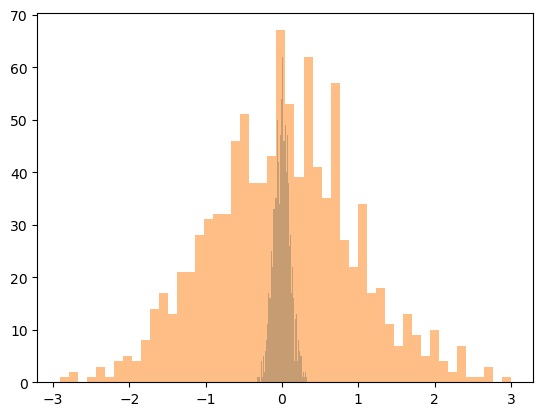

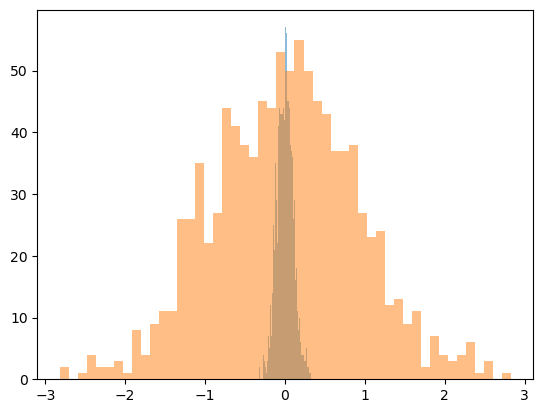

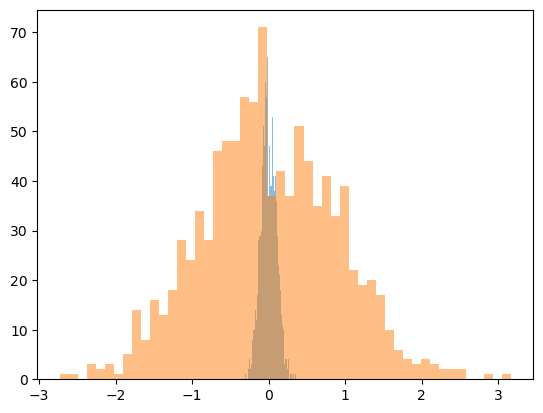

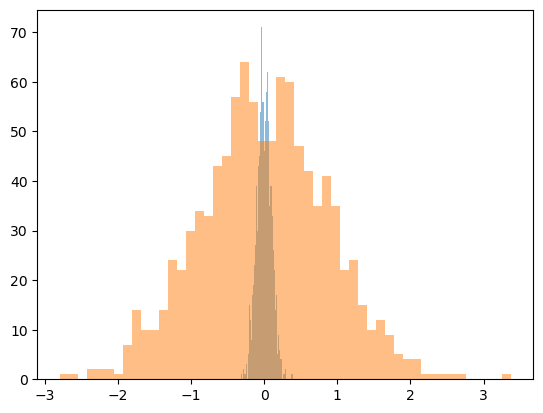

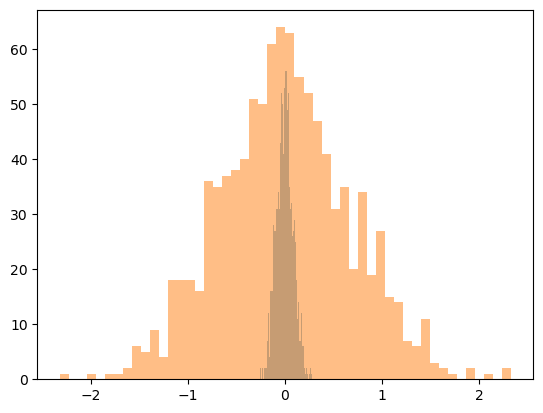

standardising


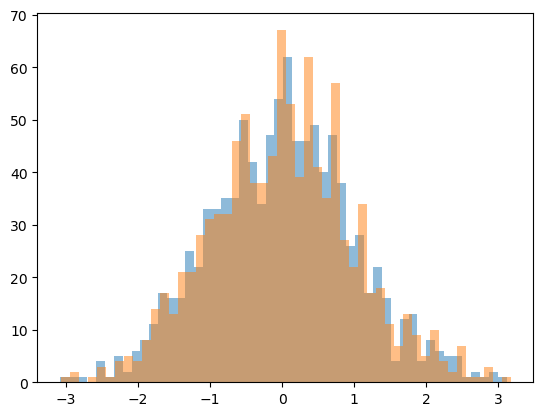

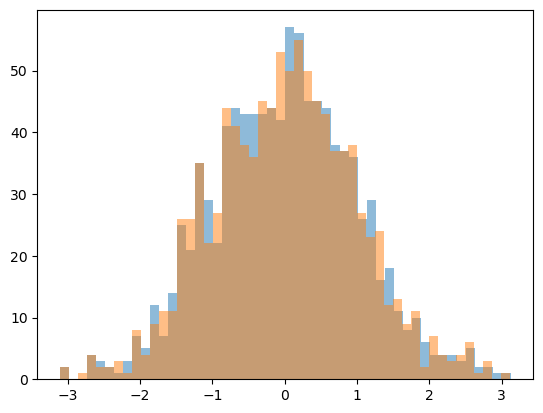

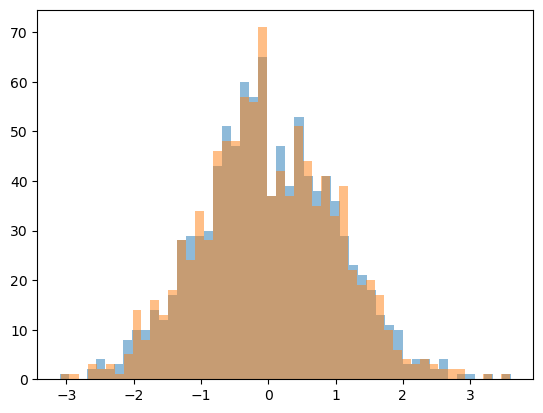

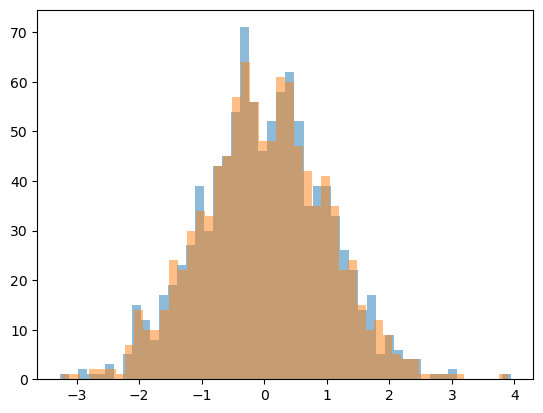

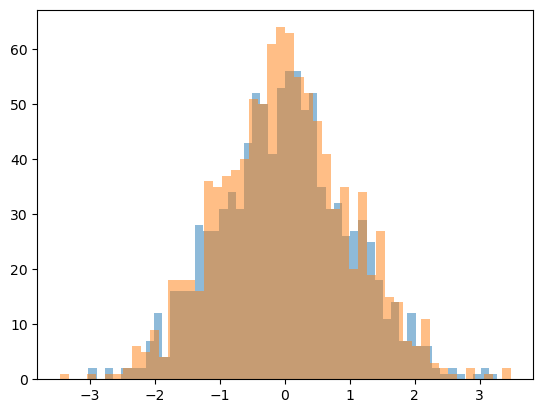

In [6]:
x_train_pca = PCA(n_components=45).fit_transform(x_train)
y_train_pca = PCA(n_components=35).fit_transform(y_train)

for i in range(5):
    plt.figure()
    plt.hist(x_train_pca[:, i], bins=50, label = f'x_train_pca {i+1}', alpha=0.5)
    plt.hist(y_train_pca[:, i], bins=50, label = f'y_train_pca {i+1}', alpha=0.5)
    plt.show()

print('standardising')

for i in range(5):
    x_train_pca_stand_i = (x_train_pca[:, i] - x_train_pca[:, i].mean(axis = 0))/x_train_pca[:, i].std(axis = 0)
    y_train_pca_stand_i = (y_train_pca[:, i] - y_train_pca[:, i].mean(axis = 0))/y_train_pca[:, i].std(axis = 0)
    plt.figure()
    plt.hist(x_train_pca_stand_i, bins=50, label = f'x_train_pca_stand {i+1}', alpha=0.5)
    plt.hist(y_train_pca_stand_i, bins=50, label = f'y_train_pca_stand {i+1}', alpha=0.5)
    plt.show()


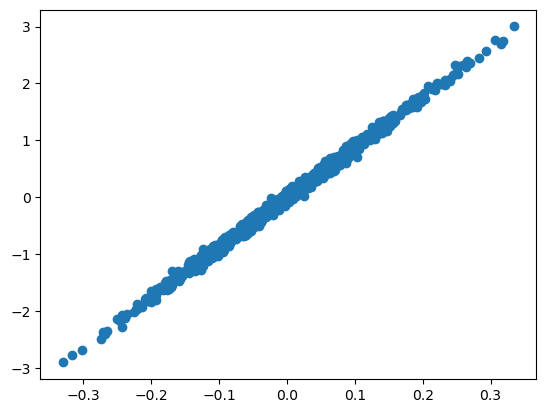

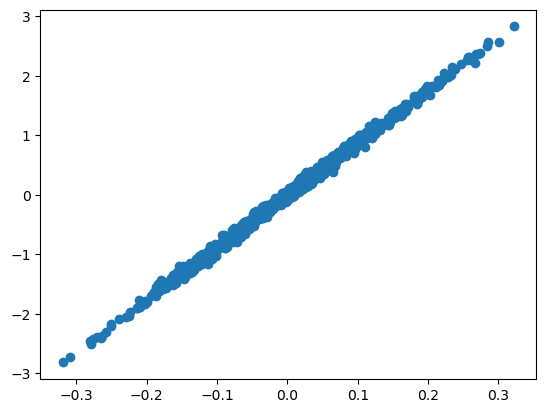

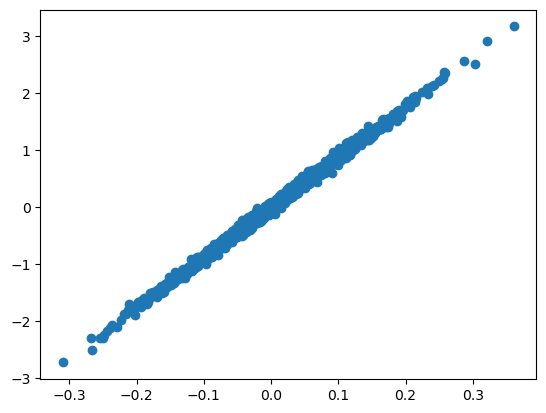

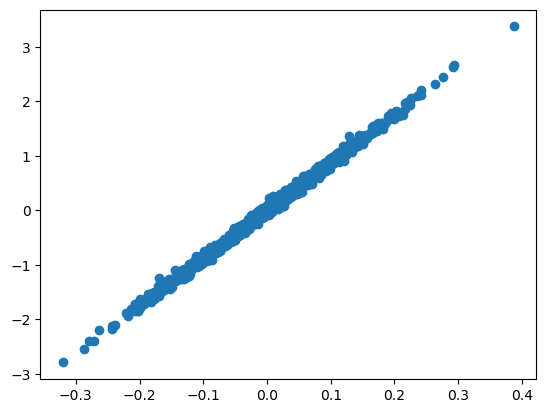

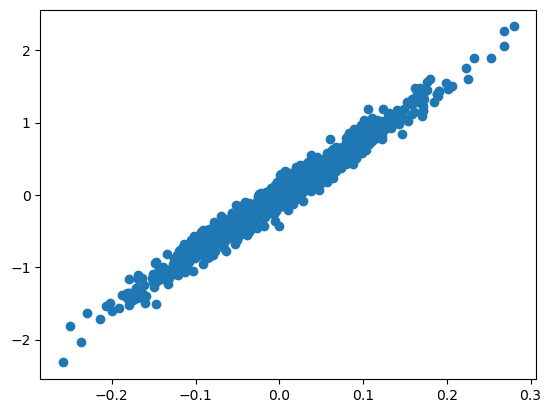

In [7]:
for i in range(5):
    plt.figure()
    plt.plot(x_train_pca[:, i], y_train_pca[:, i], 'o')
    plt.show()

In [22]:
## Train

n, m = 45, 45 # n, m = 45, 35 for variance explained 0.95, 0.99

n_samples = 6

model = full_model(n = n, m = m, ARD = False, multiinput = True, standardise = True)
train_samples = model.fit(x_train, y_train, n_samples = None)

does x pca
does y pca


  0%|          | 0/45 [00:00<?, ?it/s]

[1.]
float64


  2%|▏         | 1/45 [00:53<39:03, 53.26s/it]

Optimization terminated successfully.
         Current function value: -714.719861
         Iterations: 35
         Function evaluations: 80
         Gradient evaluations: 80
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.2295202], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100014], dtype=float64))
[1.]
[1.]
[1.]
float64


  4%|▍         | 2/45 [01:34<33:04, 46.16s/it]

Optimization terminated successfully.
         Current function value: -718.446726
         Iterations: 28
         Function evaluations: 62
         Gradient evaluations: 62
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.22781309], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100015], dtype=float64))
[1.]
[1.]
[1.]
float64


  7%|▋         | 3/45 [02:19<31:59, 45.71s/it]

Optimization terminated successfully.
         Current function value: -732.206459
         Iterations: 34
         Function evaluations: 70
         Gradient evaluations: 70
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.22163047], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100014], dtype=float64))
[1.]
[1.]
[1.]
float64


  9%|▉         | 4/45 [03:13<33:33, 49.10s/it]

Optimization terminated successfully.
         Current function value: -726.855347
         Iterations: 49
         Function evaluations: 90
         Gradient evaluations: 90
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.22401811], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100016], dtype=float64))
[1.]
[1.]
[1.]
float64


 11%|█         | 5/45 [03:54<30:37, 45.94s/it]

Optimization terminated successfully.
         Current function value: -734.017150
         Iterations: 35
         Function evaluations: 71
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.22083432], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100009], dtype=float64))
[1.]
[1.]
[1.]
float64


 13%|█▎        | 6/45 [04:51<32:18, 49.71s/it]

Optimization terminated successfully.
         Current function value: -717.590006
         Iterations: 56
         Function evaluations: 99
         Gradient evaluations: 99
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.22820253], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[1.]
[1.]
[1.]
float64


 16%|█▌        | 7/45 [05:29<29:03, 45.89s/it]

Optimization terminated successfully.
         Current function value: -727.085394
         Iterations: 34
         Function evaluations: 69
         Gradient evaluations: 69
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.22391501], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100012], dtype=float64))
[1.]
[1.]
[1.]
float64


 18%|█▊        | 8/45 [06:18<28:56, 46.93s/it]

Optimization terminated successfully.
         Current function value: -701.879782
         Iterations: 44
         Function evaluations: 87
         Gradient evaluations: 87
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.23549107], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0010002], dtype=float64))
[1.]
[1.]
[1.]
float64


 20%|██        | 9/45 [06:57<26:38, 44.40s/it]

Optimization terminated successfully.
         Current function value: -622.065624
         Iterations: 34
         Function evaluations: 71
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.27625669], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100017], dtype=float64))
[1.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 22%|██▏       | 10/45 [07:17<21:32, 36.93s/it]

         Current function value: 565.785815
         Iterations: 10
         Function evaluations: 42
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.96408871], dtype=float64), variance=Array([0.68923709], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54468091], dtype=float64))
[1.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 24%|██▍       | 11/45 [07:38<18:05, 31.92s/it]

         Current function value: 565.861666
         Iterations: 10
         Function evaluations: 42
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.96428023], dtype=float64), variance=Array([0.68928387], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54466184], dtype=float64))
[1.]
[1.]
[1.]
float64


 27%|██▋       | 12/45 [07:44<13:17, 24.17s/it]

Optimization terminated successfully.
         Current function value: 1418.938533
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.00001148], dtype=float64), variance=Array([0.70772577], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54062301], dtype=float64))
[1.]
[1.]
[1.]
float64


 29%|██▉       | 13/45 [08:34<17:06, 32.07s/it]

Optimization terminated successfully.
         Current function value: -593.457249
         Iterations: 37
         Function evaluations: 94
         Gradient evaluations: 94
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.29253224], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100011], dtype=float64))
[1.]
[1.]
[1.]
float64


 31%|███       | 14/45 [08:41<12:35, 24.36s/it]

Optimization terminated successfully.
         Current function value: 1418.938534
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.00001022], dtype=float64), variance=Array([0.70772576], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54062301], dtype=float64))
[1.]
[1.]
[1.]
float64


 33%|███▎      | 15/45 [09:20<14:25, 28.84s/it]

Optimization terminated successfully.
         Current function value: -538.525955
         Iterations: 33
         Function evaluations: 71
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.32650464], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100023], dtype=float64))
[1.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 36%|███▌      | 16/45 [09:39<12:31, 25.93s/it]

         Current function value: 573.628822
         Iterations: 8
         Function evaluations: 41
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.95417008], dtype=float64), variance=Array([0.68662827], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54559132], dtype=float64))
[1.]
[1.]
[1.]
float64


 38%|███▊      | 17/45 [10:19<14:02, 30.09s/it]

Optimization terminated successfully.
         Current function value: -551.729400
         Iterations: 34
         Function evaluations: 72
         Gradient evaluations: 72
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.31799144], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100016], dtype=float64))
[1.]
[1.]
[1.]
float64


 40%|████      | 18/45 [10:25<10:16, 22.83s/it]

Optimization terminated successfully.
         Current function value: 1418.938533
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.00001726], dtype=float64), variance=Array([0.70772577], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.540623], dtype=float64))
[1.]
[1.]
[1.]
float64


 42%|████▏     | 19/45 [11:19<13:56, 32.16s/it]

Optimization terminated successfully.
         Current function value: -532.663803
         Iterations: 41
         Function evaluations: 82
         Gradient evaluations: 82
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.33035073], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100001], dtype=float64))
[1.]
[1.]
[1.]
float64


 44%|████▍     | 20/45 [12:06<15:15, 36.61s/it]

Optimization terminated successfully.
         Current function value: -521.111825
         Iterations: 33
         Function evaluations: 68
         Gradient evaluations: 68
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.33807524], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100022], dtype=float64))
[1.]
[1.]
[1.]
float64


 47%|████▋     | 21/45 [12:13<11:06, 27.79s/it]

Optimization terminated successfully.
         Current function value: 1418.938533
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.00001336], dtype=float64), variance=Array([0.70772577], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54062301], dtype=float64))
[1.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 49%|████▉     | 22/45 [12:39<10:28, 27.31s/it]

         Current function value: 582.975903
         Iterations: 10
         Function evaluations: 44
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.96663511], dtype=float64), variance=Array([0.69016068], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54417047], dtype=float64))
[1.]
[1.]
[1.]
float64


 51%|█████     | 23/45 [13:46<14:23, 39.23s/it]

Optimization terminated successfully.
         Current function value: -328.217872
         Iterations: 56
         Function evaluations: 94
         Gradient evaluations: 94
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.49724955], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100001], dtype=float64))
[1.]
[1.]
[1.]
float64


 53%|█████▎    | 24/45 [14:44<15:41, 44.83s/it]

Optimization terminated successfully.
         Current function value: -328.428599
         Iterations: 45
         Function evaluations: 85
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.49704369], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100044], dtype=float64))
[1.]
[1.]
[1.]
float64


 56%|█████▌    | 25/45 [15:32<15:12, 45.64s/it]

Optimization terminated successfully.
         Current function value: -432.466336
         Iterations: 35
         Function evaluations: 71
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.40365548], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100019], dtype=float64))
[1.]
[1.]
[1.]
float64


 58%|█████▊    | 26/45 [16:28<15:28, 48.88s/it]

Optimization terminated successfully.
         Current function value: -391.059409
         Iterations: 40
         Function evaluations: 83
         Gradient evaluations: 83
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.43850844], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100014], dtype=float64))
[1.]
[1.]
[1.]
float64


 60%|██████    | 27/45 [17:21<15:01, 50.08s/it]

Optimization terminated successfully.
         Current function value: -422.247919
         Iterations: 36
         Function evaluations: 87
         Gradient evaluations: 87
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.41199571], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100021], dtype=float64))
[1.]
[1.]
[1.]
float64


 62%|██████▏   | 28/45 [18:09<13:59, 49.36s/it]

Optimization terminated successfully.
         Current function value: -350.464382
         Iterations: 39
         Function evaluations: 91
         Gradient evaluations: 91
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.47559522], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100012], dtype=float64))
[1.]
[1.]
[1.]
float64


 64%|██████▍   | 29/45 [18:51<12:34, 47.16s/it]

Optimization terminated successfully.
         Current function value: -338.789973
         Iterations: 42
         Function evaluations: 73
         Gradient evaluations: 73
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.4868456], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[1.]
[1.]
[1.]
float64


 67%|██████▋   | 30/45 [19:39<11:51, 47.45s/it]

Optimization terminated successfully.
         Current function value: -317.088029
         Iterations: 45
         Function evaluations: 87
         Gradient evaluations: 87
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.50844264], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100039], dtype=float64))
[1.]
[1.]
[1.]
float64


 69%|██████▉   | 31/45 [20:25<11:01, 47.22s/it]

Optimization terminated successfully.
         Current function value: -344.034993
         Iterations: 42
         Function evaluations: 85
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.48176275], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100026], dtype=float64))
[1.]
[1.]
[1.]
float64


 71%|███████   | 32/45 [21:03<09:34, 44.21s/it]

Optimization terminated successfully.
         Current function value: -303.848331
         Iterations: 35
         Function evaluations: 67
         Gradient evaluations: 67
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.52208683], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100018], dtype=float64))
[1.]
[1.]
[1.]
float64


 73%|███████▎  | 33/45 [21:49<08:56, 44.71s/it]

Optimization terminated successfully.
         Current function value: -272.649658
         Iterations: 45
         Function evaluations: 79
         Gradient evaluations: 79
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.55569258], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[1.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 76%|███████▌  | 34/45 [22:07<06:45, 36.90s/it]

         Current function value: 594.743356
         Iterations: 8
         Function evaluations: 41
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.94627696], dtype=float64), variance=Array([0.68631339], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54586653], dtype=float64))
[1.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 78%|███████▊  | 35/45 [22:27<05:17, 31.79s/it]

         Current function value: 595.999530
         Iterations: 8
         Function evaluations: 41
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.9606486], dtype=float64), variance=Array([0.68831247], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54457471], dtype=float64))
[1.]
[1.]
[1.]
float64


 80%|████████  | 36/45 [23:27<06:02, 40.31s/it]

Optimization terminated successfully.
         Current function value: -242.637708
         Iterations: 43
         Function evaluations: 84
         Gradient evaluations: 84
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.59007879], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100032], dtype=float64))
[1.]
[1.]
[1.]
float64


 82%|████████▏ | 37/45 [24:30<06:15, 46.91s/it]

Optimization terminated successfully.
         Current function value: -55.710783
         Iterations: 63
         Function evaluations: 102
         Gradient evaluations: 102
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.77734877], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.05116835], dtype=float64))
[1.]
[1.]
[1.]
float64


 84%|████████▍ | 38/45 [25:13<05:21, 45.91s/it]

Optimization terminated successfully.
         Current function value: -157.007159
         Iterations: 41
         Function evaluations: 71
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.70030515], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100017], dtype=float64))
[1.]
[1.]
[1.]
float64


 87%|████████▋ | 39/45 [26:07<04:49, 48.27s/it]

Optimization terminated successfully.
         Current function value: -43.036558
         Iterations: 52
         Function evaluations: 93
         Gradient evaluations: 93
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.77718751], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.05818438], dtype=float64))
[1.]
[1.]
[1.]
float64


 89%|████████▉ | 40/45 [26:59<04:06, 49.27s/it]

Optimization terminated successfully.
         Current function value: 4.638851
         Iterations: 50
         Function evaluations: 91
         Gradient evaluations: 91
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.86607557], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0577444], dtype=float64))
[1.]
[1.]
[1.]
float64


 91%|█████████ | 41/45 [27:54<03:24, 51.15s/it]

Optimization terminated successfully.
         Current function value: -52.548560
         Iterations: 56
         Function evaluations: 94
         Gradient evaluations: 94
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.82551737], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03448943], dtype=float64))
[1.]
[1.]
[1.]
float64


 93%|█████████▎| 42/45 [28:39<02:27, 49.30s/it]

Optimization terminated successfully.
         Current function value: 24.802337
         Iterations: 41
         Function evaluations: 81
         Gradient evaluations: 81
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.85812357], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.07087996], dtype=float64))
[1.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 96%|█████████▌| 43/45 [28:58<01:20, 40.18s/it]

         Current function value: 626.915159
         Iterations: 8
         Function evaluations: 40
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.94922398], dtype=float64), variance=Array([0.68752054], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.54520047], dtype=float64))
[1.]
[1.]
[1.]
float64


 98%|█████████▊| 44/45 [29:48<00:43, 43.08s/it]

Optimization terminated successfully.
         Current function value: 51.898994
         Iterations: 48
         Function evaluations: 88
         Gradient evaluations: 88
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.87801448], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.07958767], dtype=float64))
[1.]
[1.]
[1.]
float64


100%|██████████| 45/45 [30:32<00:00, 40.72s/it]

Optimization terminated successfully.
         Current function value: 98.926091
         Iterations: 40
         Function evaluations: 79
         Gradient evaluations: 79
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.], dtype=float64), variance=Array([0.74276654], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.1269405], dtype=float64))
[1.]
[1.]


In [23]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

100%|██████████| 45/45 [01:47<00:00,  2.40s/it]


(1000, 4096, 6)
median relative L2 (train data): 0.09451226851854269
mean relative L2 (train data): 0.09808746204137905


(1000, 4096, 6)


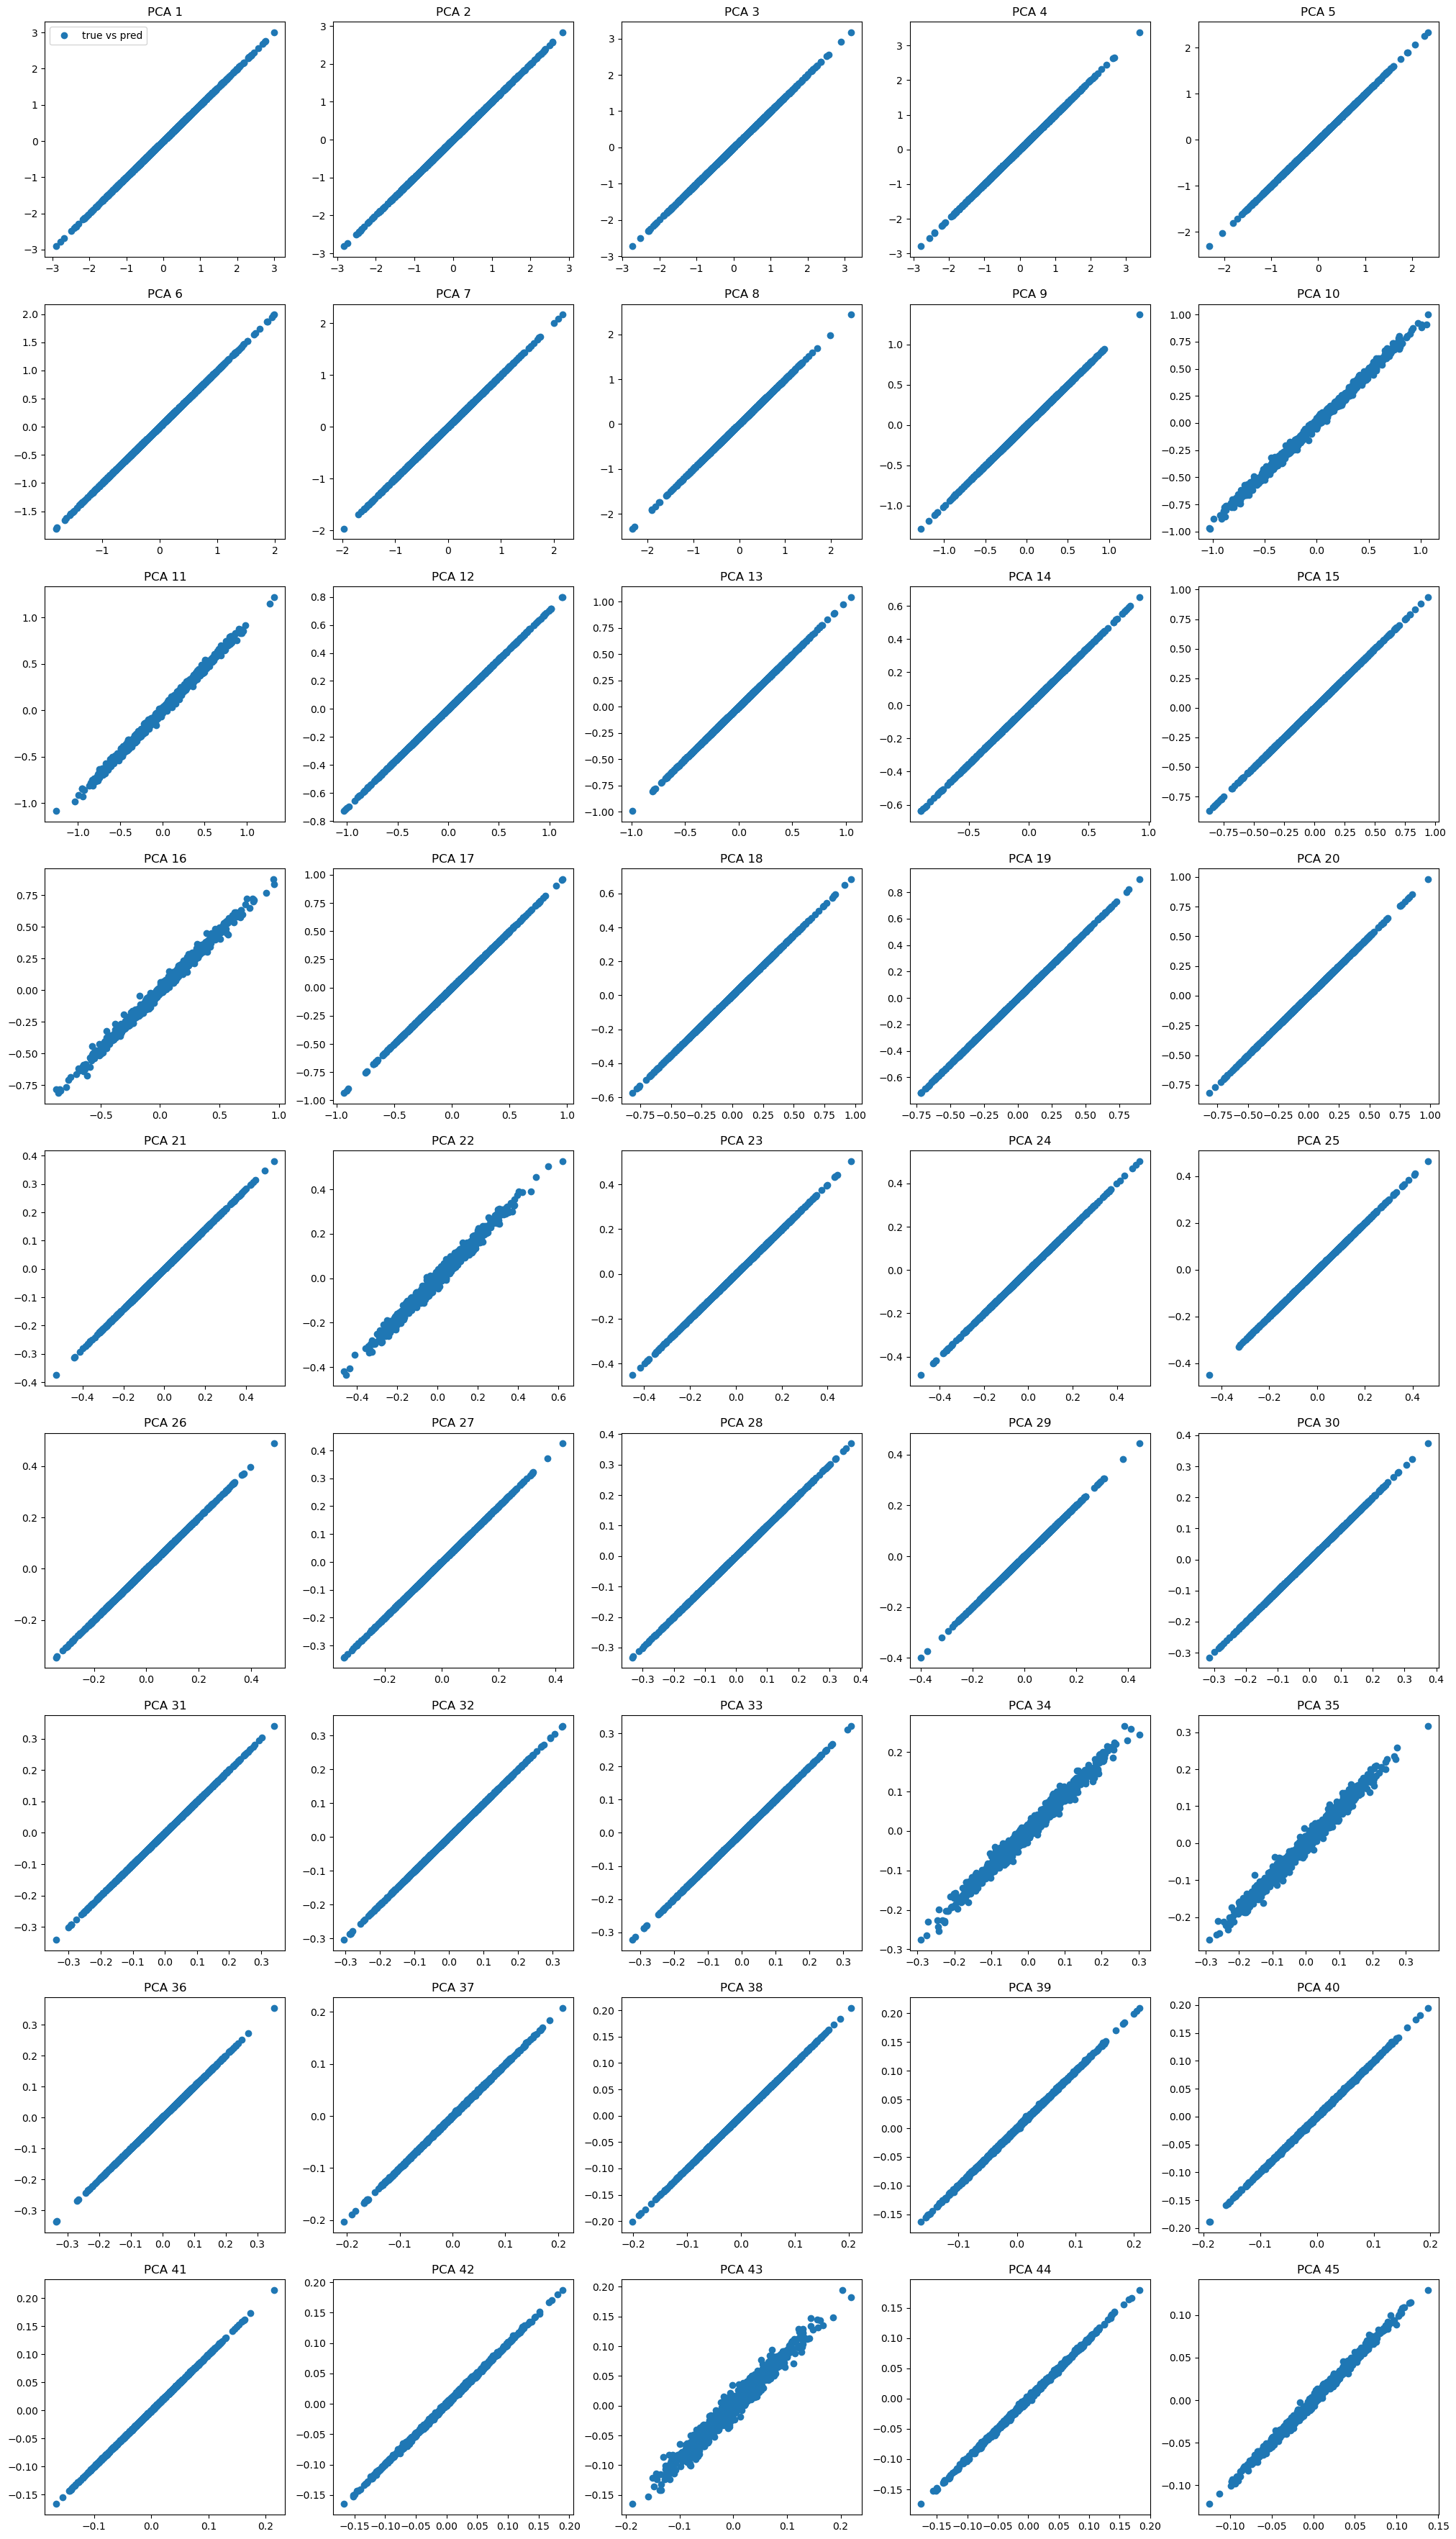

In [24]:
x_train_pca = model.x_test_pca
y_train_pca = model.y_pca.transform(y_train)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_train_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

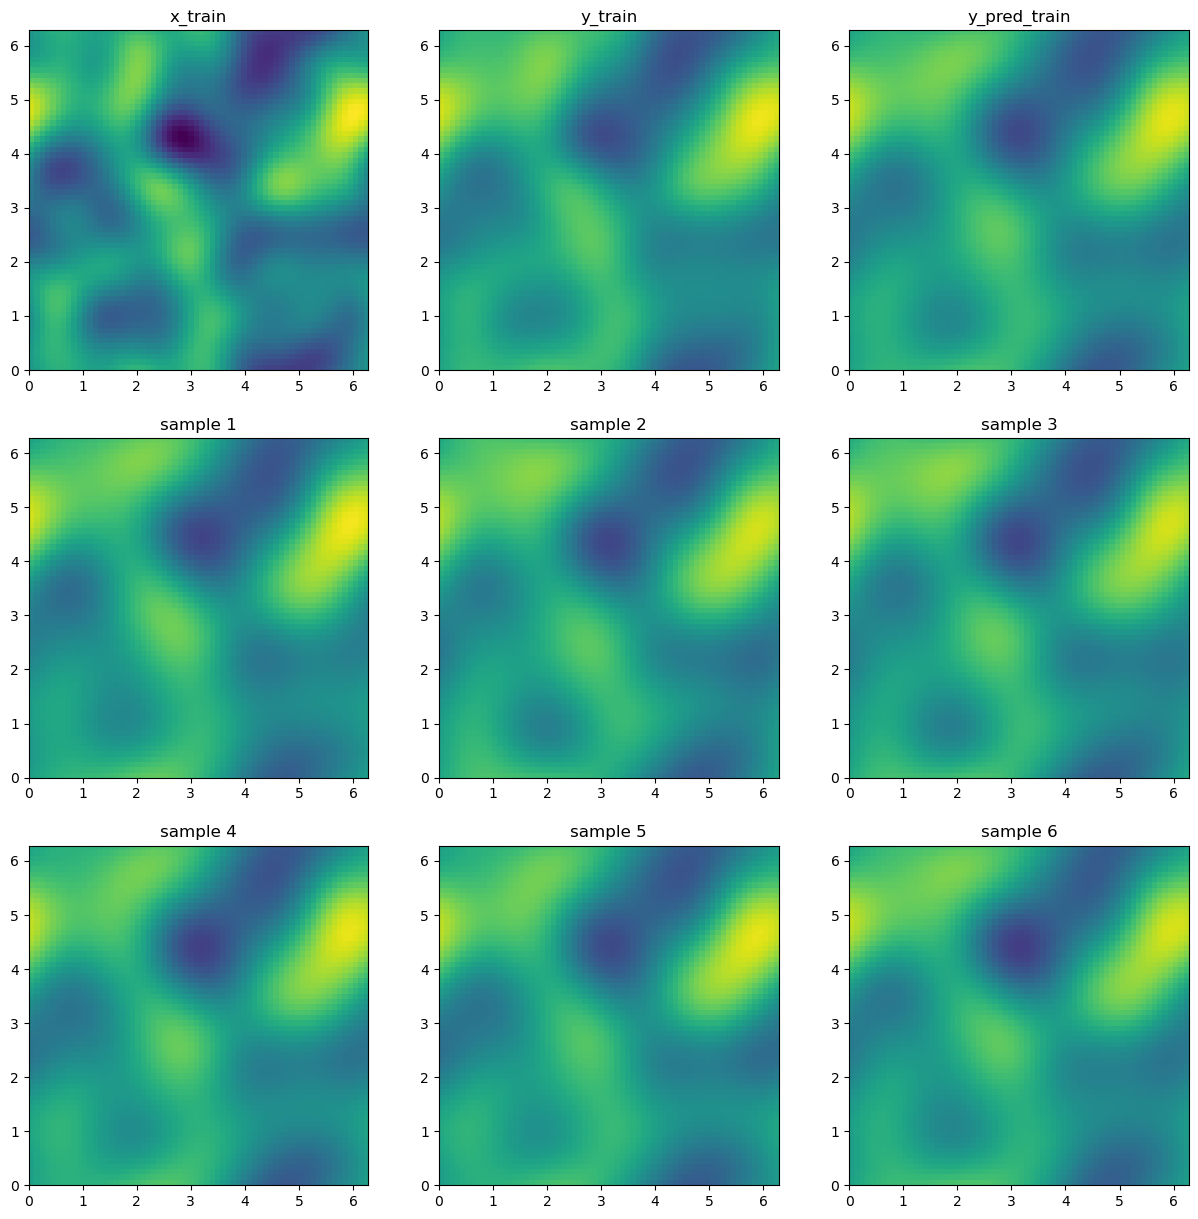

In [25]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

# testing

In [26]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

100%|██████████| 45/45 [01:44<00:00,  2.32s/it]


median relative L2: 0.23108404206984973
mean relative L2: 0.24380196074513724


(1000, 4096, 6)


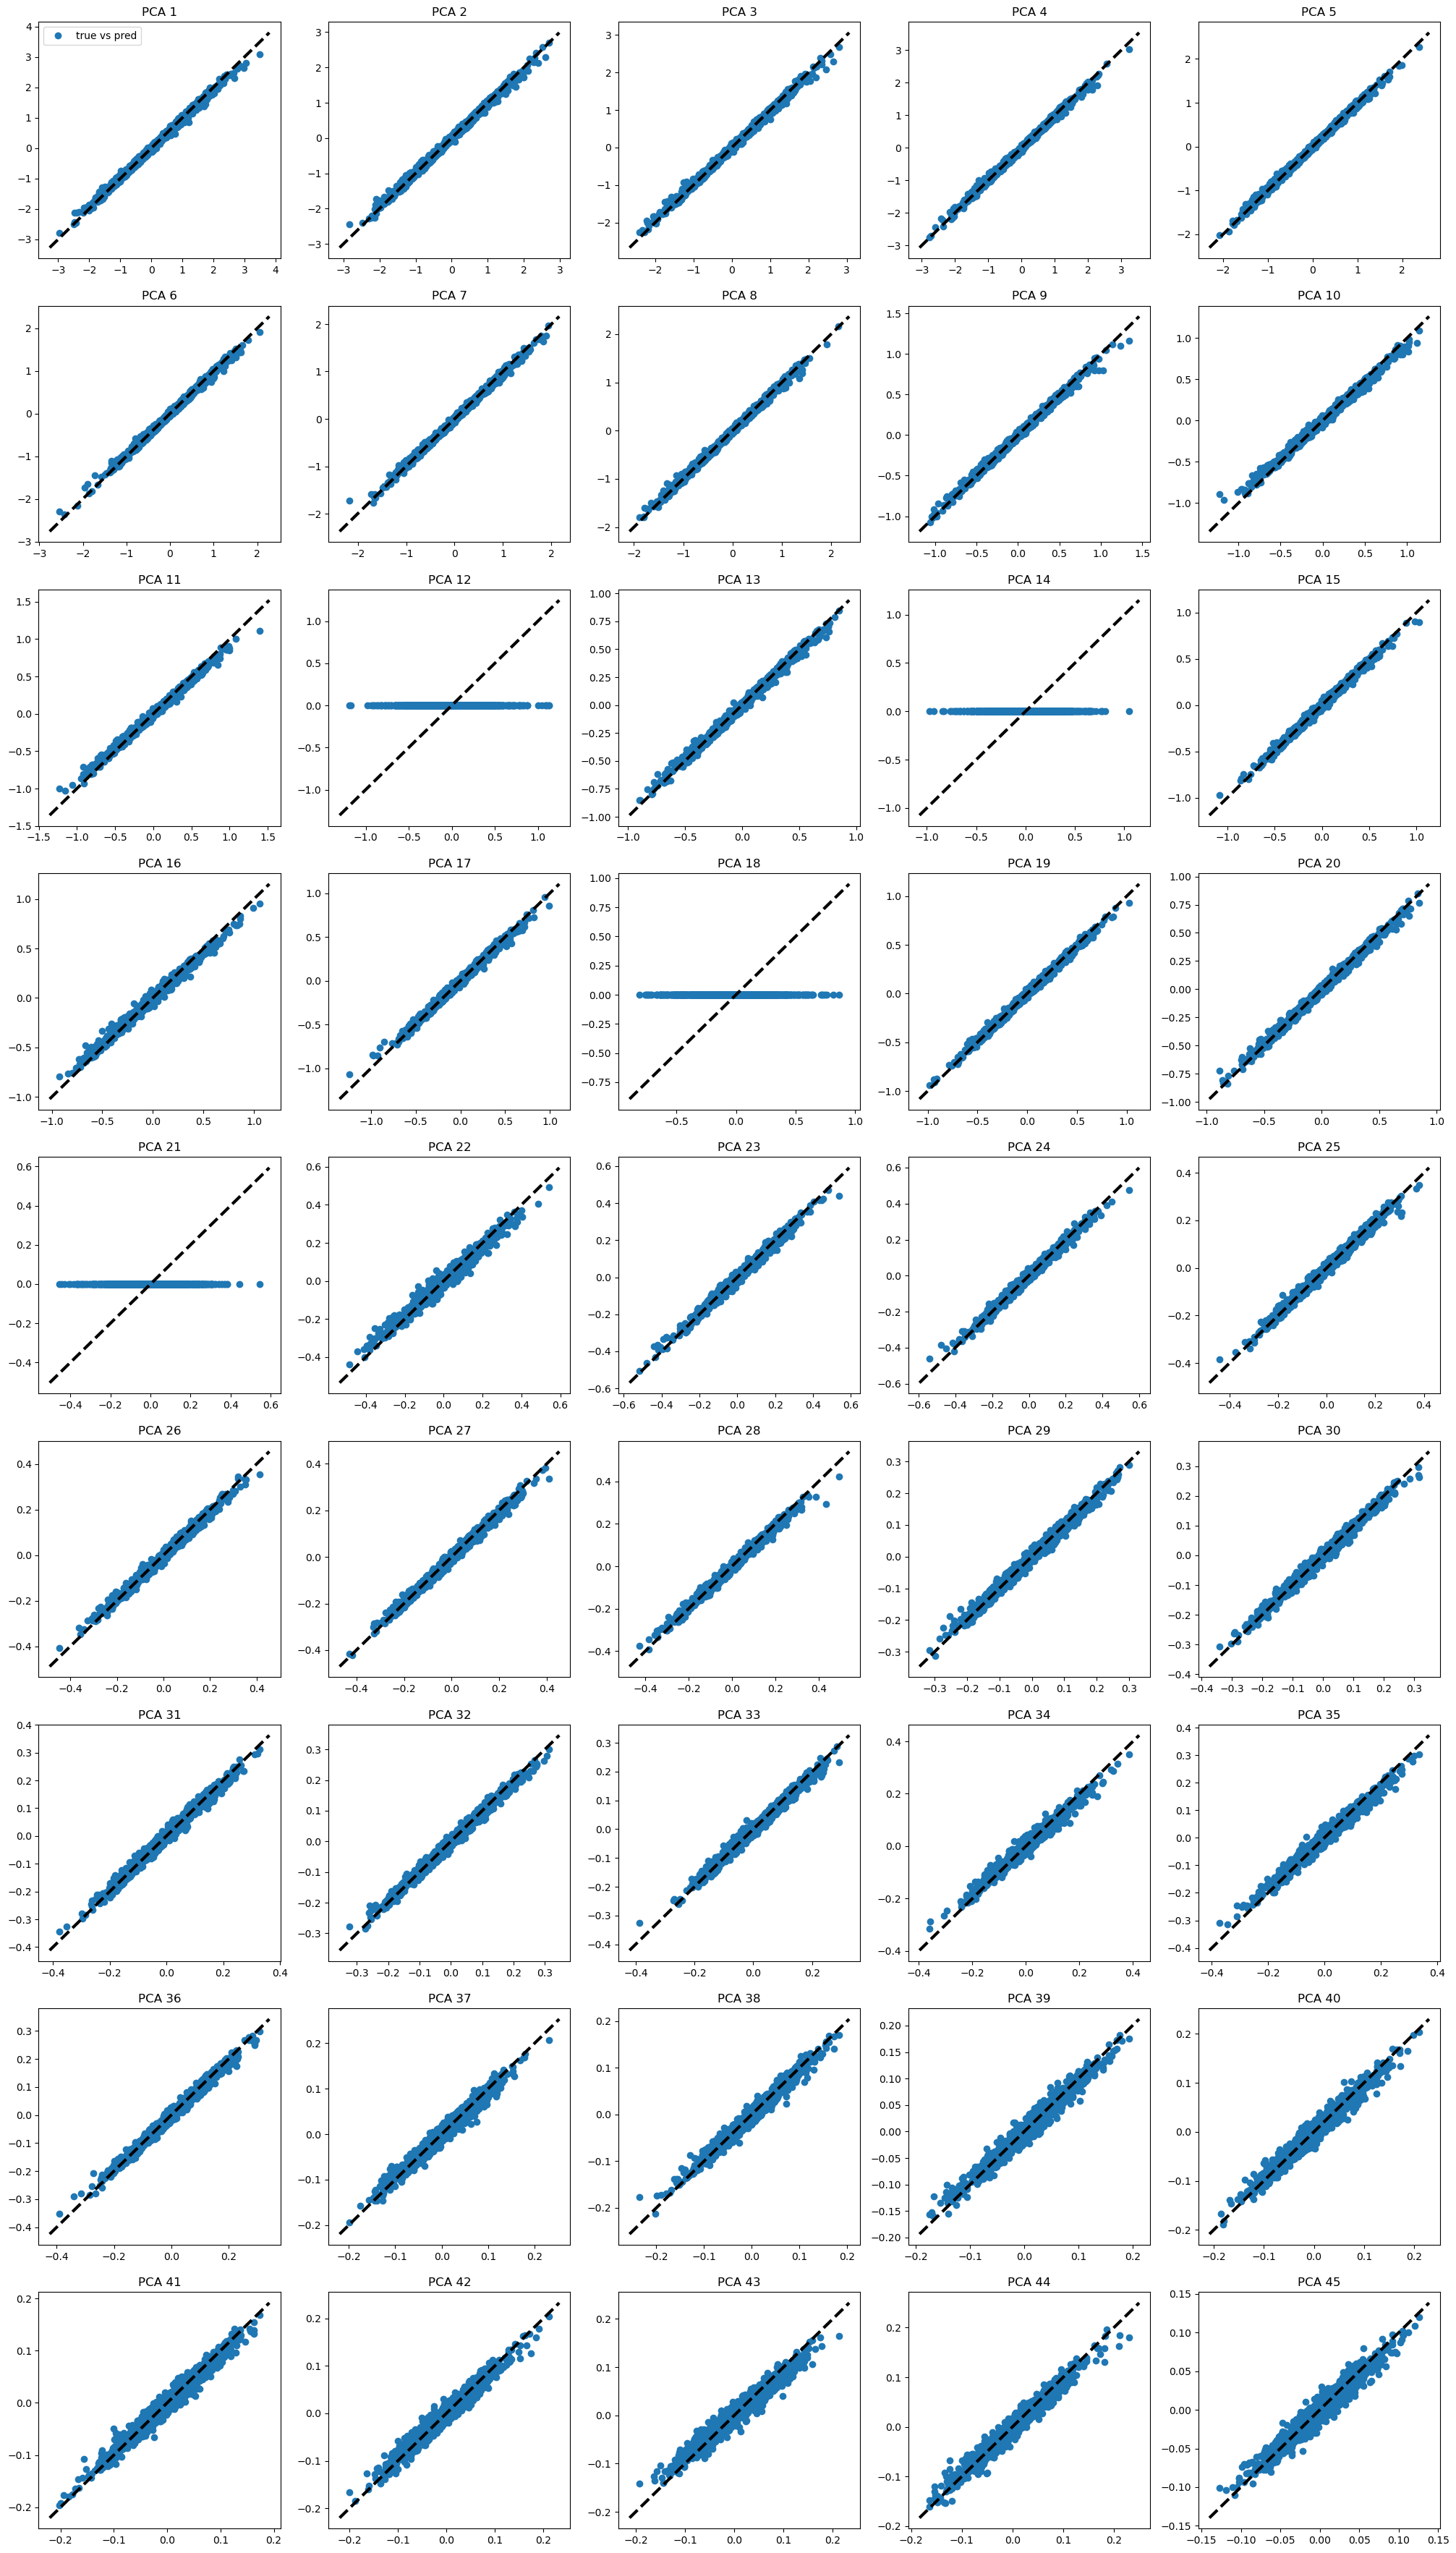

In [27]:
x_test_pca = model.x_test_pca
y_test_pca = model.y_pca.transform(y_test)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=3)
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

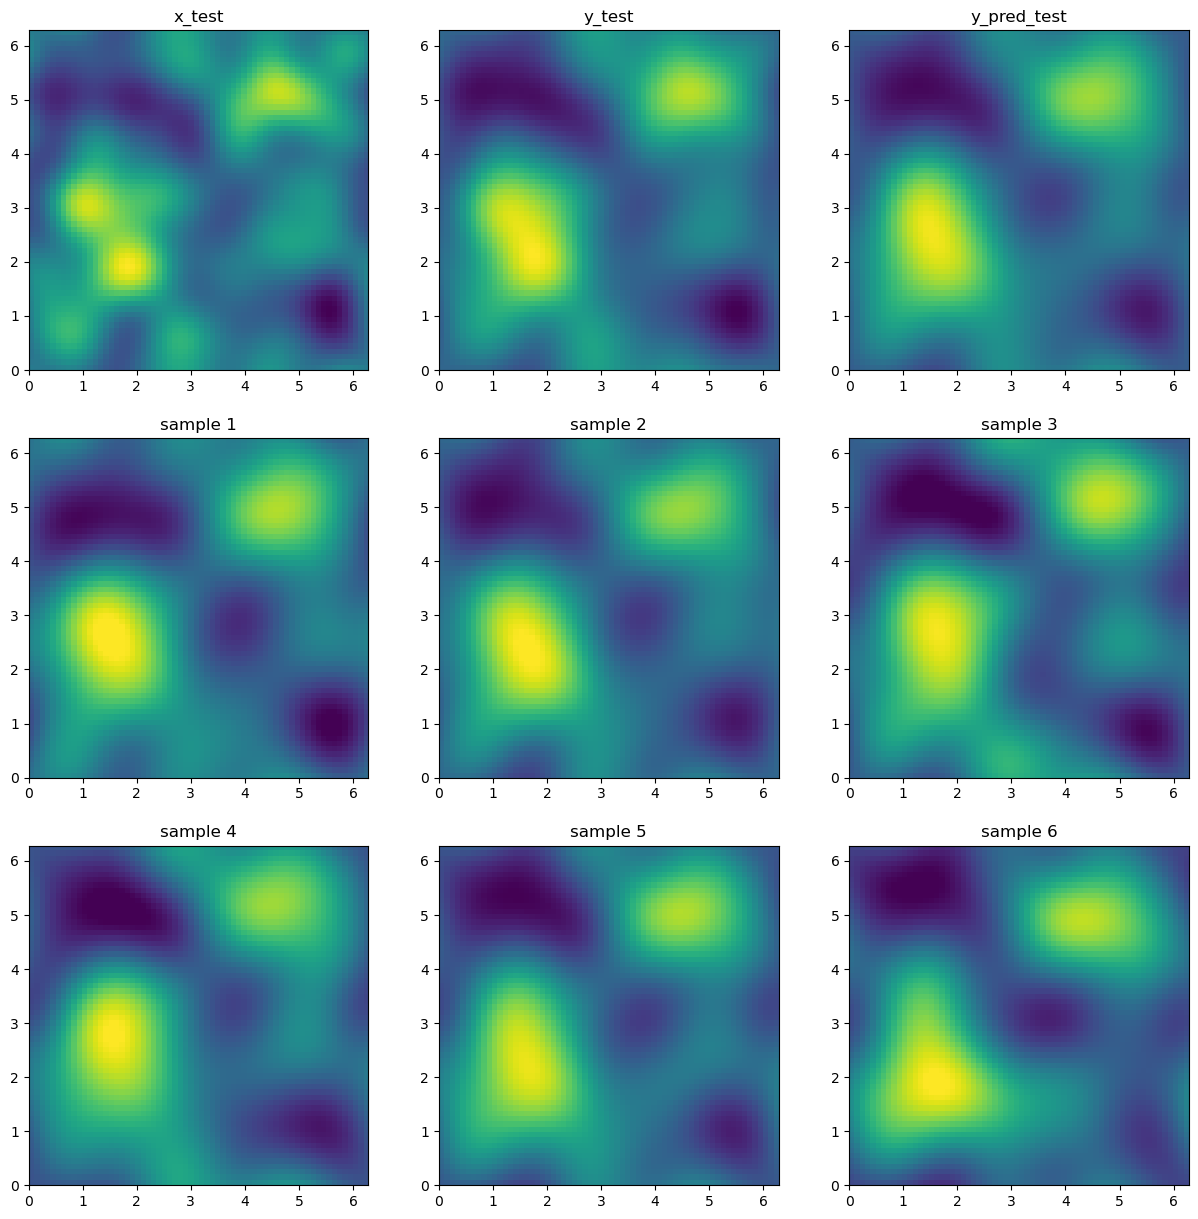

In [28]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [29]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 4096, 100)


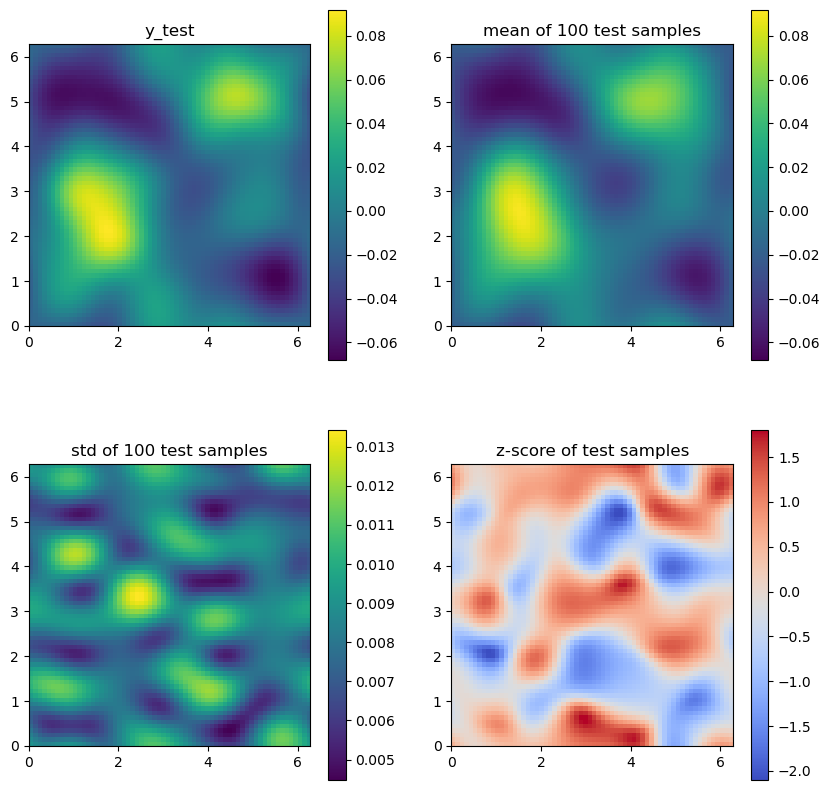

In [33]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[0].set_title("y_test")
im1 = ax[1].imshow(test_samples_mean[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title(f"mean of {n_samples} test samples")
im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[2].set_title(f"std of {n_samples} test samples")
im3 = ax[3].imshow((y_test[index_to_plot, :].reshape(64, 64) - test_samples_mean[index_to_plot, :].reshape(64, 64)) / test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap = 'coolwarm')
ax[3].set_title(f"z-score of test samples")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


Linear regression baseline

1000 128
0.05201410366190792 0.057825880066910966


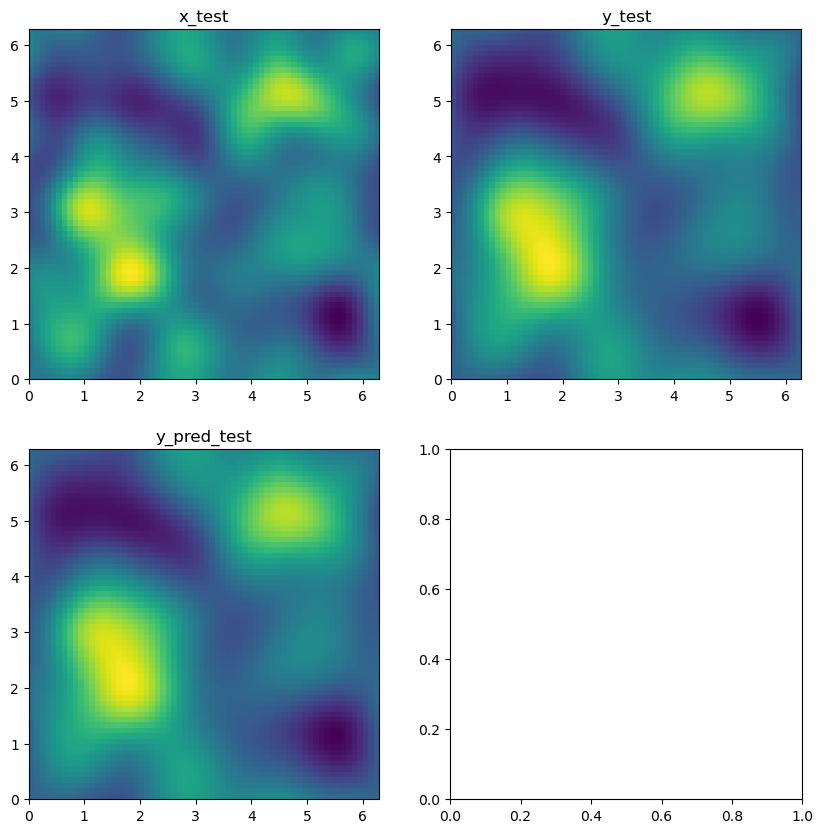

1000 256
0.052013783823677204 0.05782442051243419


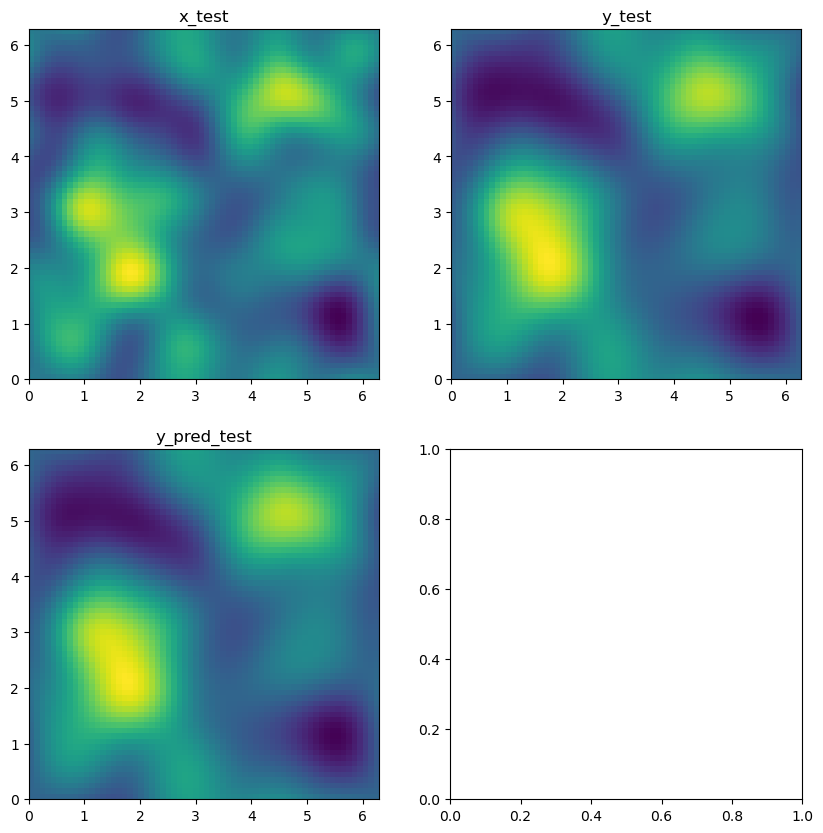

1000 512
0.05201465454171577 0.05782613210389789


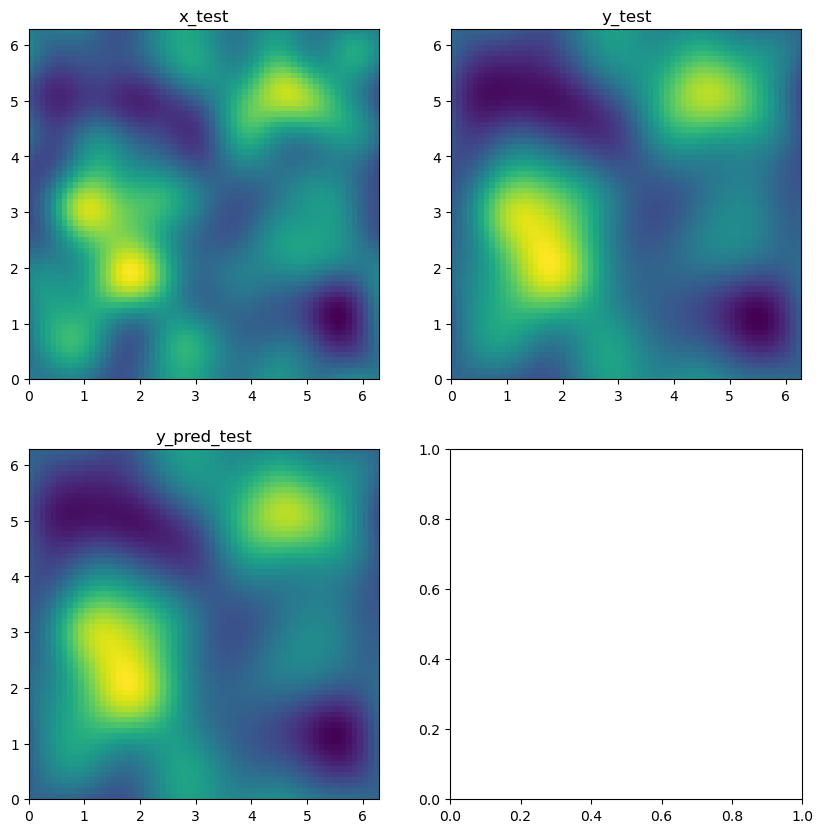

1000 1024
0.051470239119434616 0.0588309934177186


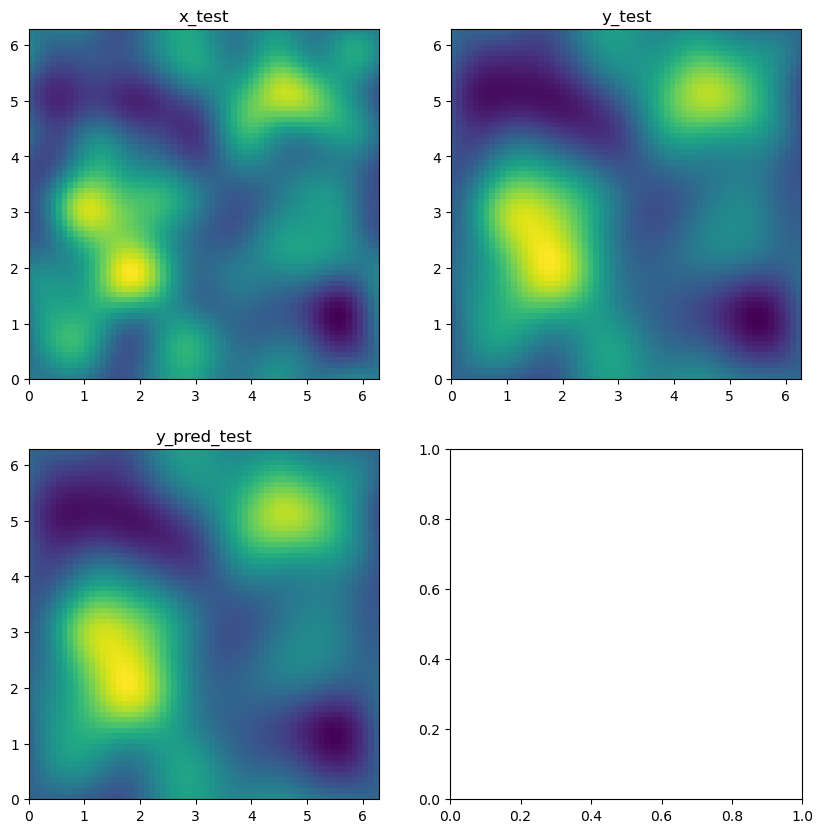

In [21]:
results = []
for Ntrain in [1000]:
    for N_components in [128, 256, 512, 1024]:
        print(Ntrain, N_components)
        Ytr = y_train
        Xtr = x_train
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = x_test
        Ytest = y_test
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(train_error, test_error)
        results.append([Ntrain, N_components, train_error, test_error])

        index_to_plot = 125

        y_lims = np.array([min(y_test[index_to_plot, :].min(), Ypred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), Ypred[index_to_plot, :].max())])

        fig, ax = plt.subplots(2, 2, figsize = (10, 10))
        ax = ax.flatten()
        im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
        ax[0].set_title("x_test")
        im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[1].set_title("y_test")
        im2 = ax[2].imshow(Ypred[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[2].set_title("y_pred_test")
        plt.show()

results = np.array(results)